# Test Fine-tuned Donut invoices

Testing the Donut model after Fine-Tuning.

## Preparation

First we'll load some variables to work locally. Set the loading variables to true when runing this for the first time.

In [1]:
dataset_id = "Aoschu/donut_model_data_for_german_invoice"

local_ds_path = "ds2_test"
local_model_path = "donut_invoice_model/invoice_ds2/20250429_214015"

load_ds_from_hub = False

save_path = f"{local_ds_path}_results/{local_model_path}"

Loading the dataset. I only used the test split.

In [2]:
from datasets import load_dataset, load_from_disk
from donut import DonutModel

if load_ds_from_hub:
    dataset = load_dataset(dataset_id, split="test")
    dataset.save_to_disk(local_ds_path)

dataset = load_from_disk(local_ds_path)
model = DonutModel.from_pretrained(local_model_path)

/home/andi/Dokumente/DONUT/.donut39/lib/python3.9/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Let's verify an example.

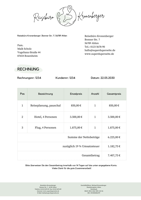

In [3]:
example_image = dataset[0]["image"]
width, height = example_image.size
display(example_image.resize((int(width*0.1), int(height*0.1))))

## Testing

Here we define the testing routine.

In [4]:
import torch
from donut import JSONParseEvaluator, save_json
import os
from tqdm.notebook import tqdm
import json
import numpy as np


def test():
    if torch.cuda.is_available():
        model.half()
        model.to("cuda")

    model.eval()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    predictions = []
    ground_truths = []
    scores={}

    evaluator = JSONParseEvaluator()

    for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
        ground_truth = json.loads(sample["ground_truth"])

        output = model.inference(image=sample["image"], prompt=f"<gt_parse>")["predictions"][0]

        gt = ground_truth["gt_parse"]

        predictions.append(output)
        ground_truths.append(gt)

    if save_path:
        scores["predictions"] = predictions
        scores["ground_truths"] = ground_truths
        save_json(save_path, scores)

    return predictions

Time to run it.

In [5]:
parsed_results = test()

  0%|          | 0/18 [00:00<?, ?it/s]

## Checking results

Let's take a look at a prediction example.

In [6]:
import pprint

pprint.pprint(parsed_results[0], indent=4)

{   'Der Name der Firma': 'Reisebiiro Kronenberger',
    'Die Adresse der Firma': 'Bonner Str. 756789 Ahlen',
    'IBAN': 'DE12 3456‘',
    'Rechnungsdatum': '22.05.2030',
    'Rechnungsnummer': '1234',
    'Summe': '7.407,75 €',
    'Telefonnummer': '0123 5678-90'}


## Evaluation

Now we can also load the ground truth data for evaluation. We'll also take a look at the first example.

In [7]:
import json

ground_truth_list = []
for data_item in dataset:

    gt_string = data_item["ground_truth"]
    parsed_data = json.loads(gt_string)

    inner_dict = parsed_data["gt_parse"]

    ground_truth_list.append(inner_dict)

ground_truth_list[:1]

[{'Der Name der Firma': 'Reisebiiro Kronenberger',
  'Die Adresse der Firma': 'Bonner Str. 756789 Ahlen',
  'Telefonnummer': '01234 5678-90',
  'Rechnungsdatum': ': 22.05.2030',
  'Summe': '7.407,75',
  'IBAN': 'DE12 3456 7890 1234 56',
  'Der Name der Bank': 'Reisebank'}]

Now we can calculate some metrics.

Notice that Precision, recall and F1-score are typically used for classification problems, not text prediction or matching key value paris. In the context of matching key value pairs, incorrect predictions are counted both as false positive and false negative.

I've also calculated the accuracy based on the normalized tree edit distance by using the [donut-python](https://pypi.org/project/donut-python/) library. The main difference here is that, while the metrics are only counting fully correct or false predicitons per field, the three edit distance also measures how "close" any given predicitons was. You might want to implement this yourself or use another library, but I simply used it because I was comparing different models, including DONUT and so this seemed to be an easy way for an an additional baseline. I've also used the donut-python library to get the f1 score which was consistent with my own implementation in this case (not in all others).

For predictions with matching keys, I've also calculated the values word error rate as i[mplemented by the torcheval library](https://pytorch.org/torcheval/main/generated/torcheval.metrics.WordErrorRate.html#torcheval.metrics.WordErrorRate).

In [9]:
from collections.abc import Mapping, Sequence # Used for type checking in flatten function
from donut import JSONParseEvaluator # The Donut JSONParseEvaluator is used for here for better comparison of the two models
import numpy as np
from torcheval.metrics import WordErrorRate

def flatten_dict(d, parent_key='', sep='.'):
    items = {}
    for k, v in d.items() if isinstance(d, Mapping) else enumerate(d):
        new_key = f"{parent_key}{sep}{k}" if parent_key else str(k)
        if isinstance(v, Mapping):
            # If the value is a dictionary, recurse
            items.update(flatten_dict(v, new_key, sep=sep))
        elif isinstance(v, Sequence) and not isinstance(v, (str, bytes)):
            # If the value is a list/tuple (but not string/bytes), recurse
             items.update(flatten_dict(v, new_key, sep=sep))
        else:
            # It's a leaf value
            items[new_key] = v
    return items

def calculate_extraction_metrics(predictions, ground_truths):

    if len(predictions) != len(ground_truths):
        print("Error: Predictions and ground truths lists must have the same length.")
        return None

    total_tp = 0  # True Positives (field correctly extracted with correct value)
    total_fp = 0  # False Positives (field extracted but shouldn't be, or wrong value)
    total_fn = 0  # False Negatives (field should have been extracted but wasn't, or wrong value)
    accs = []
    total_fields = 0
    word_error_metric = WordErrorRate()

    for i, (pred, truth) in enumerate(zip(predictions, ground_truths)):
        # Field-Level Metrics (Precision, Recall, F1)
        flat_pred = flatten_dict(pred)
        flat_truth = flatten_dict(truth)

        # Convert to sets of (key, value) tuples for comparison
        pred_items = set(flat_pred.items())
        truth_items = set(flat_truth.items())

        def filter_empty_values(data):
            return [item for item in data if item[1]]

        non_empty_pred_items = set(filter_empty_values(pred_items))

        tp = len(pred_items.intersection(truth_items))
        fp = len(non_empty_pred_items.difference(truth_items))
        fn = len(truth_items.difference(pred_items))

        total_fields += len(flat_truth)
        
        total_tp += tp
        total_fp += fp
        total_fn += fn
        
        evaluator = JSONParseEvaluator()
        acc_score = evaluator.cal_acc(pred, truth)
        accs.append(float(acc_score))

        def get_word_error_rate(input, target):
            for input_item in input:
                for target_item in target:
                    if input_item[0] == target_item[0]:
                        word_error_metric.update(input_item[1], target_item[1])

        get_word_error_rate(pred_items, truth_items)


        # Log TP, FP, FN for the a single dataset item
        log_item_details = 100 # Set number of item you want to log
        if i == log_item_details:
            print(f"Details for the dataset item no. {log_item_details+1}:\n")
            print("  True Positives:")
            for item in pred_items.intersection(truth_items):
                print(f"    {item}")

            print("\n  False Positives:")
            for item in non_empty_pred_items.difference(truth_items):
                print(f"    {item}")

            print("\n  False Negatives:")
            for item in truth_items.difference(pred_items):
                print(f"    {item}")
            print("\n")

    # Micro-average Precision, Recall, F1
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    mean_accuracy = np.mean(accs)
    f1_eval = evaluator.cal_f1(predictions, ground_truths)
    word_error_rate = word_error_metric.compute()

    return {
        "precision": precision,
        "recall": recall, 
        "f1_score": f1,
        "f1_eval": f1_eval,
        "mean_accuracy": mean_accuracy,
        "total_tp": total_tp,
        "total_fields": total_fields,
        "word_error_rate": word_error_rate,   
    }

# Calculate and Print Metrics
if parsed_results and ground_truth_list:
    metrics = calculate_extraction_metrics(parsed_results, ground_truth_list)
    print(f"Parsed {len(ground_truth_list)} items with a total of {metrics['total_fields']} fields to predict.")
    print()
    if metrics:
        print("Validation Metrics:")
        print(f"  Total True Positives:             {metrics['total_tp']}")
        print(f"  Precision:                        {metrics['precision']:.4f}")
        print(f"  Recall:                           {metrics['recall']:.4f}")
        print(f"  F1-Score (manual score):          {metrics['f1_score']:.4f}")
        print(f"  F1-Score (evaluator):             {metrics['f1_eval']:.4f}")
        print(f"  Accuracy (Tree Edit Distance):    {metrics['mean_accuracy']:.4f}")
        print(f"  Word Error Rate:                  {metrics['word_error_rate']:.4f}")

else:
    print("No valid lists provided for predictions and/or ground truths.")

Parsed 18 items with a total of 113 fields to predict.

Validation Metrics:
  Total True Positives:             29
  Precision:                        0.3625
  Recall:                           0.2566
  F1-Score (manual score):          0.3005
  F1-Score (evaluator):             0.3005
  Accuracy (Tree Edit Distance):    0.3224
  Word Error Rate:                  0.5049
